# Demo

In [1]:
import iris, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

connection = iris.connect("localhost:51777/NYTAXI", "_SYSTEM", "SYS")

import warnings
warnings.simplefilter("ignore")

# utility vars and function to compare metrics
last_time = 0
last_grefs = 0
plans = []

def reset_compare():
    global last_time, last_grefs
    last_time = 0
    last_grefs = 0

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "faster" if speed else "less")
        else:
            return " - {:,.0%} {}".format(rate-1, "faster" if speed else "less")
    else:
        rate = new / prev
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "slower" if speed else "more")
        else:
            return " - {:,.0%} {}".format(rate-1, "slower" if speed else "more")

def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0][0]
    c1.close()
    return result  

def query(sql, compare = True, dtypes = None):
    global last_time, last_grefs, plans
    
    plans.append(just_sql("EXPLAIN "+sql))
    
    start_grefs = just_sql("SELECT NYTaxi.GloRefs()")
    
    start_time = time.time()
    result = pd.read_sql_query(sql, connection, dtype = dtypes)
    exec_time = time.time() - start_time
    
    exec_grefs = just_sql("SELECT NYTaxi.GloRefs()") - start_grefs - 1
    
    if compare:
        print("\nExecution time: {:.3f}s ".format(exec_time) + brag(last_time, exec_time))
        print("Global references: {:,} ".format(exec_grefs) + brag(last_grefs, exec_grefs, False))
        last_time = exec_time
        last_grefs = exec_grefs
    else:
        print("\nExecution time: {:.3f}s\nGlobal references: {:,}".format(exec_time, exec_grefs))
    
    return result


## A first look around

```SQL
  SELECT passenger_count AS "Passengers",
         COUNT(*) AS "count"
    FROM NYTaxi.Rides2 
GROUP BY passenger_count 
ORDER BY passenger_count DESC
```


Execution time: 0.700s
Global references: 1,019


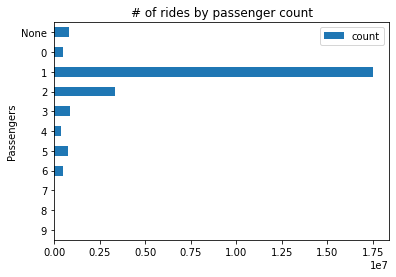

In [4]:
r = query("SELECT passenger_count AS \"Passengers\", "+
                "COUNT(*) AS \"count\" "+
          "FROM NYTaxi.Rides2 "+
          "GROUP BY passenger_count "+
          "ORDER BY passenger_count DESC", False)

r.plot.barh(x='Passengers',y='count',title="# of rides by passenger count");

## Forcing 2021.1 behaviour

```sql
SELECT %NORUNTIME AVG(total_amount) 
  FROM NYTaxi.RowRides2 
WHERE passenger_count > 2
      AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'
```

In [8]:
reset_compare()
query("SELECT %NORUNTIME AVG(total_amount) "+
        "FROM NYTaxi.RowRides2 "+
        "WHERE passenger_count > 2 "+
              "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'")


Execution time: 15.503s 
Global references: 31,341,809 


,Aggregate_1
0,18.772439


## Now using Adaptive Mode, ON by default in 2022.1

```sql
SELECT AVG(total_amount) 
  FROM NYTaxi.RowRides2 
WHERE passenger_count > 2
      AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'
```

In [9]:
query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.RowRides2 "+
             "WHERE passenger_count > 2 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'")


Execution time: 1.878s  - 8.26x faster
Global references: 2,490,964  - 12.58x less


,Aggregate_1
0,18.772439


## Why are these parameters special?

```sql
SELECT BUCKET_POSITION, PERCENTILE, VALUE
  FROM INFORMATION_SCHEMA.COLUMN_HISTOGRAMS
 WHERE TABLE_SCHEMA = 'NYTaxi'
       AND TABLE_NAME = 'RowRides2'
       AND COLUMN_NAME = 'tpep_pickup_datetime'
```


Execution time: 0.110s
Global references: 37,799


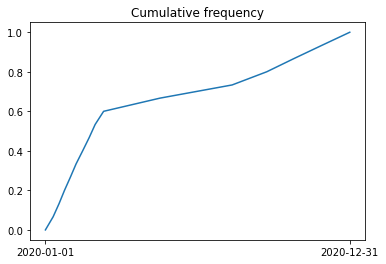

In [10]:
r = query("SELECT BUCKET_POSITION, PERCENTILE, VALUE, CAST((VALUE+0) AS POSIXTIME) AS DATE_VALUE "+
          "FROM INFORMATION_SCHEMA.COLUMN_HISTOGRAMS "+
          "WHERE TABLE_SCHEMA = 'NYTaxi' "+
                "AND TABLE_NAME = 'RowRides2' "+
                "AND COLUMN_NAME = 'tpep_pickup_datetime'", False)
plt.plot(r['VALUE'], r['PERCENTILE'])
plt.xticks(ticks=[r['VALUE'].min(), r['VALUE'].max()], 
           labels=[r['DATE_VALUE'].min()[0:10], r['DATE_VALUE'].max()[0:10]])
plt.title('Cumulative frequency')
plt.show()

## How about 10x faster?

In [11]:
query("SELECT AVG(total_amount) "+
        "FROM NYTaxi.Rides2 "+
       "WHERE passenger_count > 2 "+
             "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'")


Execution time: 0.125s  - 15.02x faster
Global references: 1,500  - 1,660.64x less


,Aggregate_1
0,18.772439
